In [1]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedKFold
from pathlib import Path
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import random


# Import custom project code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/Aperiodic_sleep_paper/helpers")
from utils import compute_z_values, compute_cliffs_delta, bonferroni_correction, friedman_dunns

In [2]:
# Load files 
# get the staging list
path_files = '/home/b1044271/Columbia/Results/Slope_Knee_over_stages/'
path_folder = Path(path_files)

# GET FIXED MODEL FILES
search_string = 'Exp_n'
Fixed_files = []

for filename in os.listdir(path_folder):
    # check if the search string is in the filename
    if search_string in filename:
        Fixed_files.append(filename)


# GET KNEE MODEL FILES
search_string = 'Exp_w'
Knee_files = []

for filename in os.listdir(path_folder):
    # check if the search string is in the filename
    if search_string in filename:
        Knee_files.append(filename)

In [3]:
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)

# Set up the repeated k-fold cross-validation
lin_method = RepeatedStratifiedKFold (n_splits = 5, n_repeats = 2, random_state = 1)


In [4]:
# Load and Prepare subject vectors for decoding

Slope_K_W = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_W.npy') #load files - knee 
Slope_F_W = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_W.npy') #load files - no knee
Slope_30_W = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_W.npy') #load files - no knee
Knee_K_W = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Kn_t15_F45_W.npy') #load files - no knee

Slope_K_N1 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_N1.npy') #load files - knee 
Slope_F_N1 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_N1.npy') #load files - no knee
Slope_30_N1 = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_N1.npy') #load files - no knee
Knee_K_N1 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Kn_t15_F45_N1.npy') #load files - no knee
  
Slope_K_N2 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_N2.npy') #load files - knee 
Slope_F_N2 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_N2.npy') #load files - no knee
Slope_30_N2 = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_N2.npy') #load files - no knee
Knee_K_N2 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Kn_t15_F45_N2.npy') #load files - no knee
     
Slope_K_N3 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_N3.npy') #load files - knee 
Slope_F_N3 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_N3.npy') #load files - no knee
Slope_30_N3 = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_N3.npy') #load files - no knee
Knee_K_N3 = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Kn_t15_F45_N3.npy') #load files - no knee
 
    
Slope_K_R = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_wKnee_t15_F45_R.npy') #load files - knee 
Slope_F_R = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Exp_nKnee_t15_F45_R.npy') #load files - no knee
Slope_30_R = np.load('/home/b1044271/Columbia/Results/Paper/' + 'Exp_nKnee_t15_F3045_R.npy') #load files - no knee
Knee_K_R = np.load('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/' + 'Kn_t15_F45_R.npy') #load files - no knee


/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Without including KNEE frequency
## since  that means fewer subjects
### Here N = 17

In [5]:
# Set up the repeated k-fold cross-validation
lin_method = RepeatedKFold(n_splits=5, n_repeats=2)

accuracy_K=[]
accuracy_F=[]
accuracy_F30=[]
trials=np.zeros(17)*np.nan

for i in np.arange(17):
    ##########################################
    # WAKE
    W_K = Slope_K_W[i][~np.isnan(Slope_K_W[i])]
    W_F = Slope_F_W[i][~np.isnan(Slope_F_W[i])]
    W_30= Slope_30_W[i][~np.isnan(Slope_30_W[i])]
    
    l1k=np.ones(len(W_K))
    l1f=np.ones(len(W_F))
    l130=np.ones(len(W_30))

    ##############################################
    # N1
    N1_K = Slope_K_N1[i][~np.isnan(Slope_K_N1[i])]
    N1_F = Slope_F_N1[i][~np.isnan(Slope_F_N1[i])]
    N1_30= Slope_30_N1[i][~np.isnan(Slope_30_N1[i])]  
    
    l2k=np.ones(len(N1_K))*2
    l2f=np.ones(len(N1_F))*2
    l230=np.ones(len(N1_30))*2

    ###############################################
    # N2
    N2_K = Slope_K_N2[i][~np.isnan(Slope_K_N2[i])]
    N2_F = Slope_F_N2[i][~np.isnan(Slope_F_N2[i])]
    N2_30= Slope_30_N2[i][~np.isnan(Slope_30_N2[i])] 
    
    l3k=np.ones(len(N2_K))*3
    l3f=np.ones(len(N2_F))*3   
    l330=np.ones(len(N2_30))*3
      
    ###########################################
    # N3
    N3_K = Slope_K_N3[i][~np.isnan(Slope_K_N3[i])]
    N3_F = Slope_F_N3[i][~np.isnan(Slope_F_N3[i])]
    N3_30= Slope_30_N3[i][~np.isnan(Slope_30_N3[i])]
    
    l4k=np.ones(len(N3_K))*4
    l4f=np.ones(len(N3_F))*4
    l430=np.ones(len(N3_30))*4

    #################################################
    # REM
    R_K = Slope_K_W[i][~np.isnan(Slope_K_R[i])]
    R_F = Slope_F_W[i][~np.isnan(Slope_F_R[i])]
    R_30= Slope_30_R[i][~np.isnan(Slope_30_R[i])]
    
    l5k=np.ones(len(R_K))*5
    l5f=np.ones(len(R_F))*5
    l530=np.ones(len(R_30))*5
    
    Knee_model  = np.concatenate((W_K,N1_K,N2_K,N3_K,R_K))
    Fixed_model  = np.concatenate((W_F,N1_F,N2_F,N3_F,R_F))
    F30_model   = np.concatenate((W_30,N1_30,N2_30,N3_30,R_30))
    ########################################################
    # remove any nans
    y1 = np.concatenate((l1k,l2k,l3k,l4k,l5k))
    y2 = np.concatenate((l1f,l2f,l3f,l4f,l5f))
    y3 = np.concatenate((l130,l230,l330,l430,l530))
    
    Z =  np.argwhere(np.isnan(Knee_model))
    Knee_model = np.delete(Knee_model,Z)
    y1 = np.delete(y1,Z)
    
    Z2 =  np.argwhere(np.isnan(Fixed_model))
    Fixed_model = np.delete(Fixed_model,Z2)
    y2 = np.delete(y2,Z2)
    
    Z3 =  np.argwhere(np.isnan(F30_model))
    F30_model = np.delete(F30_model,Z3)
    y3 = np.delete(y3,Z3)
    ##########################################################
    # equalize number of trials
    M = min([len(y1) , len(y2), len(y3)])
    trials[i]= M # number of trials per subject
    
    a = random.sample(range(0, len(Knee_model)), M)    
    b = random.sample(range(0, len(Fixed_model)), M)
    c = random.sample(range(0, len(F30_model)), M)    
    
    Knee_model = Knee_model[a]
    Fixed_model = Fixed_model[b]
    F30_model = F30_model[c] 

    y1 = y1[a]
    y2 = y2[b]
    y3 = y3[c]

    # make the 1d array a 2d array (req for scikit learn)
    X=Knee_model[:, None]
    X2=Fixed_model[:, None]
    X3=F30_model[:, None]
    
    #########################################################
    #ACTUAOL DECODING
    ###########################################################
    # KNEE MODEL _ EXP
    ####################
    # Initialize the LDA classifier
    lda = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score = cross_val_score(lda, X, y1, scoring = 'accuracy', cv = lin_method)
    # Split the data into training and test sets
    X_train, X_test , y_train, y_test = train_test_split(X, y1, test_size=0.2)
    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)
    # Evaluate the model on the test data
    accuracy_K.append(lda.score(X_test, y_test))
    # Print the accuracy for this fold
    
    ###########################################################
    # FIXED MODEL _ EXP
    ####################    
    # Initialize the LDA classifier
    lda2 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score2 = cross_val_score(lda2, X2, y2, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train2, X_test2 , y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)
    # Fit the LDA model on the training data
    lda2.fit(X_train2, y_train2)
    # Evaluate the model on the test data
    accuracy_F.append(lda2.score(X_test2, y_test2))

    ###########################################################
    # SIMPLE MODEL _ EXP
    ####################
    # Initialize the LDA classifier
    lda3 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score3 = cross_val_score(lda3, X3, y3, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train3, X_test3 , y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2)
    # Fit the LDA model on the training data
    lda3.fit(X_train3, y_train3)
    # Evaluate the model on the test data
    accuracy_F30.append(lda3.score(X_test3, y_test3))


### Plotting results

/tmp/ipykernel_213365/992061734.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titles)


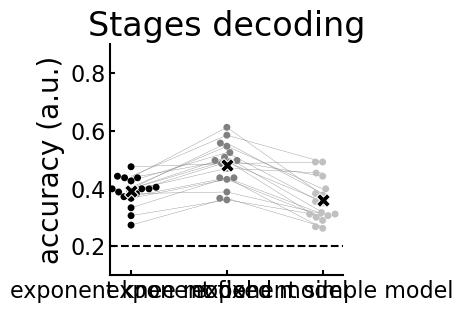

In [6]:
array_list = [ accuracy_K, accuracy_F, accuracy_F30]

titles =  ['exponent knee model','exponent fixed model','exponent simple model']
colors = ['black', 'grey', 'silver']

ax = plt.figure(figsize=(3,3))  

ax = seaborn.swarmplot(data=array_list, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2], y=np.mean(array_list,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list[0], array_list[1], array_list[2]], color = 'grey', linewidth = 0.25, linestyle = '-');
ax.axhline(y=0.2, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(0.1, 0.9)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_decoding_NoKnee.svg", dpi = 600)

##### Statistics 
##### Permutation against chance then Friedmann

In [26]:
# permutation
from utils import calculate_t_statistic, calculate_cohens_d, perform_permutation_test

# Specify the number of permutations
num_permutations = 10000

tvalue=np.zeros(3)
pvalue=np.zeros(3)
cohend=np.zeros(3)
for i in np.arange(len(array_list)):
    X = array_list[i]
    # Perform the permutation test
    tvalue[i],pvalue[i],cohend[i] = perform_permutation_test(X, np.ones(17)*0.2, num_permutations)

pvalue_bonf = pvalue * len(array_list)

In [7]:
data = pd.DataFrame(np.transpose(array_list))
friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

# WITH THE KNEE FREQUENCY

In [17]:
# Set up the repeated k-fold cross-validation
lin_method = RepeatedKFold(n_splits=5, n_repeats=2)

subj_2_excl = [2,3,4,8,9,11,12,13]

accuracy_K=[]
accuracy_F=[]
accuracy_F30=[]
accuracy_knee = []
for i in np.arange(17):
   
    # skip subjects who have a NaN
    if np.isin(i, subj_2_excl):
        continue
        
    ##########################################
    # WAKE
    W_K = Slope_K_W[i][~np.isnan(Slope_K_W[i])]
    W_F = Slope_F_W[i][~np.isnan(Slope_F_W[i])]
    W_30= Slope_30_W[i][~np.isnan(Slope_30_W[i])]
    W_knee = Knee_K_W[i][~np.isnan(Knee_K_W[i])]
    
    l1k=np.ones(len(W_K))
    l1f=np.ones(len(W_F))
    l130=np.ones(len(W_30))
    l1kn =np.ones(len(W_knee))

    ##############################################
    # N1
    N1_K = Slope_K_N1[i][~np.isnan(Slope_K_N1[i])]
    N1_F = Slope_F_N1[i][~np.isnan(Slope_F_N1[i])]
    N1_30= Slope_30_N1[i][~np.isnan(Slope_30_N1[i])]  
    N1_knee = Knee_K_N1[i][~np.isnan(Knee_K_N1[i])]
    
    l2k=np.ones(len(N1_K))*2
    l2f=np.ones(len(N1_F))*2
    l230=np.ones(len(N1_30))*2
    l2kn =np.ones(len(N1_knee))*2

    ###############################################
    # N2
    N2_K = Slope_K_N2[i][~np.isnan(Slope_K_N2[i])]
    N2_F = Slope_F_N2[i][~np.isnan(Slope_F_N2[i])]
    N2_30= Slope_30_N2[i][~np.isnan(Slope_30_N2[i])] 
    N2_knee = Knee_K_N2[i][~np.isnan(Knee_K_N2[i])]
    
    l3k=np.ones(len(N2_K))*3
    l3f=np.ones(len(N2_F))*3   
    l330=np.ones(len(N2_30))*3
    l3kn =np.ones(len(N2_knee))*3
      
    ###########################################
    # N3
    N3_K = Slope_K_N3[i][~np.isnan(Slope_K_N3[i])]
    N3_F = Slope_F_N3[i][~np.isnan(Slope_F_N3[i])]
    N3_30= Slope_30_N3[i][~np.isnan(Slope_30_N3[i])]
    N3_knee = Knee_K_N3[i][~np.isnan(Knee_K_N3[i])]
    
    l4k=np.ones(len(N3_K))*4
    l4f=np.ones(len(N3_F))*4
    l430=np.ones(len(N3_30))*4
    l4kn =np.ones(len(N3_knee))*4

    #################################################
    # REM
    R_K = Slope_K_W[i][~np.isnan(Slope_K_R[i])]
    R_F = Slope_F_W[i][~np.isnan(Slope_F_R[i])]
    R_30= Slope_30_R[i][~np.isnan(Slope_30_R[i])]
    R_knee = Knee_K_R[i][~np.isnan(Knee_K_R[i])]
    
    l5k=np.ones(len(R_K))*5
    l5f=np.ones(len(R_F))*5
    l530=np.ones(len(R_30))*5
    l5kn =np.ones(len(R_knee))*5
    
    Knee_model  = np.concatenate((W_K,N1_K,N2_K,N3_K,R_K))
    Fixed_model  = np.concatenate((W_F,N1_F,N2_F,N3_F,R_F))
    F30_model   = np.concatenate((W_30,N1_30,N2_30,N3_30,R_30))
    Knee_Fr   = np.concatenate((W_knee,N1_knee,N2_knee,N3_knee,R_knee))

    # remove any nans
    y1 = np.concatenate((l1k,l2k,l3k,l4k,l5k))
    y2 = np.concatenate((l1f,l2f,l3f,l4f,l5f))
    y3 = np.concatenate((l130,l230,l330,l430,l530))
    y4 = np.concatenate((l1kn,l2kn,l3kn,l4kn,l5kn))
    
    Z =  np.argwhere(np.isnan(Knee_model))
    Knee_model = np.delete(Knee_model,Z)
    y1 = np.delete(y1,Z)
    
    Z2 =  np.argwhere(np.isnan(Fixed_model))
    Fixed_model = np.delete(Fixed_model,Z2)
    y2 = np.delete(y2,Z2)
    
    Z3 =  np.argwhere(np.isnan(F30_model))
    F30_model = np.delete(F30_model,Z3)
    y3 = np.delete(y3,Z3)
    
    Z4 =  np.argwhere(np.isnan(Knee_Fr))
    Knee_Fr = np.delete(Knee_Fr,Z4)
    y4 = np.delete(y4,Z4)
    
    # equalize number of trials
    M = min([len(y1) , len(y2), len(y3), len(y4)])
    print( {M})
    
    
    a = random.sample(range(0, len(Knee_model)), M)    
    b = random.sample(range(0, len(Fixed_model)), M)
    c = random.sample(range(0, len(F30_model)), M)    
    d = random.sample(range(0, len(Knee_Fr)), M)    
    
    
    Knee_model = Knee_model[a]
    Fixed_model = Fixed_model[b]
    F30_model = F30_model[c] 
    Knee_Fr = Knee_Fr[d] 
    
    y1 = y1[a]
    y2 = y2[b]
    y3 = y3[c]
    y4 = y4[d]

    # make the 1d array a 2d array (req for scikit learn)
    X=Knee_model[:, None]
    X2=Fixed_model[:, None]
    X3=F30_model[:, None]
    X4=Knee_Fr[:,None]
    
    ###########################################################
    # KNEE MODEL _ EXP
    ####################
    # Initialize the LDA classifier
    lda = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score = cross_val_score(lda, X, y1, scoring = 'accuracy', cv = lin_method)
    # Split the data into training and test sets
    X_train, X_test , y_train, y_test = train_test_split(X, y1, test_size=0.2)
    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)
    # Evaluate the model on the test data
    accuracy_K.append(lda.score(X_test, y_test))
    # Print the accuracy for this fold
    print(f"Accuracy: {lda.score(X_test, y_test)}")

    
    ###########################################################
    # FIXED MODEL _ EXP
    ####################    
    # Initialize the LDA classifier
    lda2 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score2 = cross_val_score(lda2, X2, y2, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train2, X_test2 , y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)
    # Fit the LDA model on the training data
    lda2.fit(X_train2, y_train2)
    # Evaluate the model on the test data
    accuracy_F.append(lda2.score(X_test2, y_test2))
    # Print the accuracy for this fold
    print(f"Accuracy: {lda2.score(X_test2, y_test2)}")
    
    ###########################################################
    # SIMPLE MODEL _ EXP
    ####################
    # Initialize the LDA classifier
    lda3 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score3 = cross_val_score(lda3, X3, y3, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train3, X_test3 , y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2)
    # Fit the LDA model on the training data
    lda3.fit(X_train3, y_train3)
    # Evaluate the model on the test data
    accuracy_F30.append(lda3.score(X_test3, y_test3))
    print(f"Accuracy: {lda3.score(X_test3, y_test3)}")
    
    ###########################################################
    # KNEE MODEL _ EXP
    ####################
    # Initialize the LDA classifier
    lda4 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score4 = cross_val_score(lda4, X4, y4, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2)
    # Fit the LDA model on the training data
    lda4.fit(X_train4, y_train4)
    # Evaluate the model on the test data
    accuracy_knee.append(lda4.score(X_test4, y_test4))   
    print(f"Accuracy: {lda4.score(X_test4, y_test4)}")


{540}
Accuracy: 0.39814814814814814
Accuracy: 0.4722222222222222
Accuracy: 0.39814814814814814
Accuracy: 0.32407407407407407
{233}
Accuracy: 0.3404255319148936
Accuracy: 0.3829787234042553
Accuracy: 0.2765957446808511
Accuracy: 0.5106382978723404
{528}
Accuracy: 0.39622641509433965
Accuracy: 0.5471698113207547
Accuracy: 0.3018867924528302
Accuracy: 0.33962264150943394
{603}
Accuracy: 0.2892561983471074
Accuracy: 0.512396694214876
Accuracy: 0.4380165289256198
Accuracy: 0.4462809917355372
{405}
Accuracy: 0.4444444444444444
Accuracy: 0.5308641975308642
Accuracy: 0.30864197530864196
Accuracy: 0.3950617283950617
{523}
Accuracy: 0.5142857142857142
Accuracy: 0.5714285714285714
Accuracy: 0.3523809523809524
Accuracy: 0.49523809523809526
{417}
Accuracy: 0.4642857142857143
Accuracy: 0.5
Accuracy: 0.3333333333333333
Accuracy: 0.47619047619047616
{677}
Accuracy: 0.4485294117647059
Accuracy: 0.5514705882352942
Accuracy: 0.4264705882352941
Accuracy: 0.41911764705882354
{449}
Accuracy: 0.4777777777777

/tmp/ipykernel_213365/686620275.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titles)


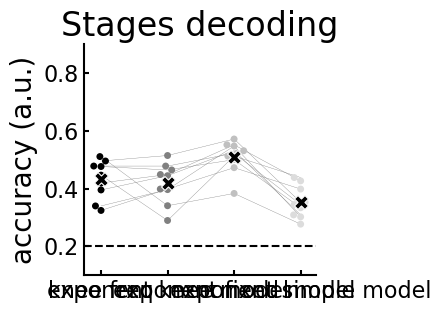

In [18]:
array_list = [accuracy_knee, accuracy_K, accuracy_F, accuracy_F30]


titles =  ['knee freq','exponent knee model','exponent fixed model','exponent simple model']
colors = ['black', 'grey', 'silver', 'gainsboro']


ax = plt.figure(figsize=(3,3))  

ax = seaborn.swarmplot(data=array_list, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2,3], y=np.mean(array_list,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list[0], array_list[1], array_list[2], array_list[3]], color = 'grey', linewidth = 0.25, linestyle = '-');
ax.axhline(y=0.2, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(0.1, 0.9)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_decoding_wknee.svg", dpi = 600)



# STATS

## Against chance

In [28]:
from utils import calculate_t_statistic, calculate_cohens_d, perform_permutation_test


# Specify the number of permutations
num_permutations = 10000

tvalue=np.zeros(4)
pvalue=np.zeros(4)
cohend=np.zeros(4)
for i in np.arange(len(array_list)):
    X = array_list[i]
    # Perform the permutation test
    tvalue[i],pvalue[i],cohend[i] = perform_permutation_test(X, np.ones(9)*0.2, num_permutations)

pvalue_bonf = pvalue * len(array_list)

In [32]:
cohend

array([4.87178292, 4.38175039, 7.82474408, 3.83750842])

In [34]:
tvalue

array([10.33461221,  9.29509624, 16.5987888 ,  8.14058468])

## Friedman

In [38]:
data = pd.DataFrame(np.transpose(array_list))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)


In [39]:
corrected_p_values

,0,1,2,3
0,1.000000,1.000000,0.185025,0.379778
1,1.000000,1.000000,0.106232,0.600383
2,0.185025,0.106232,1.000000,0.000355
3,0.379778,0.600383,0.000355,1.000000


In [42]:
friedman_result

FriedmanchisquareResult(statistic=21.701492537313424, pvalue=1.9390132241278643e-05)